<a href="https://colab.research.google.com/github/zxzhaixiang/MachineLearning_demo/blob/master/DQN_Reinforcement_Learning_on_GYM_Atari.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep-Q-Network (DQN) Learning on Breakout

In this notebook, we will be training a Deep Q Network reinforcement learning model to play Breakout game using the OpenAI GYM game simulator.

Breakout is an ideal game for DQN for several reasons

- Breakout is deterministic. Given the state of the game (location and velocity of the ball), an optimal decision exists and it is not (that) stochastic. DQN, by its definition, aims to find a deterministic Q function given state and action. Thus DQN is ideal for games like Breakout.
- The action space is, TINY. In fact, only left or right. This helps us to construct DQN in a very simple way: input is a vector of game state, and output is the Q value at each action.

The Q network takes the screen output of the game (state) as input, and outputs the expected optimal Q value for each action.

In this notebook, we will be using "BreakoutNoFrameskip-v4" environmnet. Without too much modification, the same workflow should work (almost) seamlessly for many other Atari games, such as Pong, etc. Note that DQN is more for deterministic strategy, so it is more suitable for games requiring fast action and little room to wonder around.

After the DQN is trained with 10,000 episodes, it is able to achieve 300+ points!

![DQN playing Breakout](https://raw.githubusercontent.com/zxzhaixiang/MachineLearning_demo/master/assets/BreakoutNoFrameskip-v4-4000-489frame_351.0.gif)


To keep Colab from timeout, Press F12 and paste the following JavaScript code the the console.

```JavaScript
ClickConnect(){
    console.log("Working");
    document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
```

# Colab Installs + Regular Imports
If you're running this script outside of a notebook set Colab to 'False'
gsync allows this notebook to save pretrained models directly to your Google Drive account

In [1]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=f64f4f05420a4390983fa1e4b2a60a57978624c9812305eb74116c4e4872f325
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 26.4 GB  | Proc size: 156.4 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [2]:
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install torchviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 7 not upgraded.
Need to get 783 kB of archives.
After this operation, 2,266 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.3 [783 kB]
Fetched 783 kB in 1s (795 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 145674 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.3_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.3) ...
Setting up xvfb (2:1.19.6-1ubuntu4.3) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     |████████████████████████████████| 51kB 2.9MB/s 
  Created wheel for torchviz: filen

In [0]:
# Google Colab PyTorch utilities

import time
import numpy as np
import collections
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import cv2
import gym
import gym.spaces
from torchsummary import summary
from torchviz import make_dot

In [0]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc
%matplotlib inline

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device is {}'.format(device))

device is cuda


### Mount Google Drive to save/load model weights (Optional)
It is time consuming to train reinforcement learning, even for such a simple game. Colab only gives us 12 hr of usage. Although it is enough for game like Breakout, we still want to save the model weight somewhere eles in case we want to do a hot restart. The simplest solution is to mount your google drive and save the model weight there. It is completely optional.

In [7]:
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Configurations

Parameters
* REPLAY_SIZE: Maximum number of experiences stored in replay memory
* TARGET_UPDATE_FREQ: How many frames in between syncing target DQN with behaviour DQN
* LEARNING_STARTS: Number of experiences to add to replay memory before training network

In [0]:
# ENV_NAME = "PongNoFrameskip-v4"
ENV_NAME = "BreakoutNoFrameskip-v4"
MODEL = "BreakoutNoFrameskip-v4.dat"
GDRIVE_FOLDER = "BreakoutModels"

MEAN_REWARD_BOUND = 50

FRAME_SKIPPING = 8

GAMMA = 0.95
BATCH_SIZE = 32
REPLAY_SIZE = 10 ** 5 * 2
LEARNING_STARTS = 10**4 * 2

LEARNING_RATE = 1e-5
TARGET_UPDATE_FREQ = 10000

EPSILON_DECAY = 10**5 * 5
EPSILON_START = 0.9
EPSILON_FINAL = 0.1

MODEL_SAVE_STEP = 200 

LOAD_MODEL_NAME = 'BreakoutNoFrameskip-v4-4400.dat' #set to null if cold start

In [0]:
SAVE_FOLDER = os.path.join('/content/drive/My Drive/',GDRIVE_FOLDER)
if (not os.path.isdir(SAVE_FOLDER)):
    os.mkdir(SAVE_FOLDER)

# OpenAI Gym Wrappers
These wrappers make it easier to interact with OpenAI Gym

Wrappers include:


*   Frame skipping
*   Frame processing (downsampling and greyscaling)
* Image normalization and converting to PyTorch



In [0]:
# Taken from OpenAI baseline wrappers
# https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py

class FireResetEnv(gym.Wrapper):
    def __init__(self, env=None):
        """Take action on reset for environments that are fixed until firing."""
        super(FireResetEnv, self).__init__(env)
        print(env.unwrapped.get_action_meanings())
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def step(self, action):
        return self.env.step(action)

    def reset(self):
        self.env.reset()
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset()
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset()
        return obs


class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        """Return only every `skip`-th frame"""
        super(MaxAndSkipEnv, self).__init__(env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, info

    def reset(self):
        """Clear past frame buffer and init to first obs"""
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs


class ProcessFrame84(gym.ObservationWrapper):
    """
    Downsamples image to 84x84
    Greyscales image

    Returns numpy array
    """
    def __init__(self, env=None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)

    def observation(self, obs):
        return ProcessFrame84.process(obs)

    @staticmethod
    def process(frame):
        if frame.size == 210 * 160 * 3:
            img = np.reshape(frame, [210, 160, 3]).astype(np.float32)
        elif frame.size == 250 * 160 * 3:
            img = np.reshape(frame, [250, 160, 3]).astype(np.float32)
        else:
            assert False, "Unknown resolution."
        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = np.reshape(x_t, [84, 84, 1])
        return x_t.astype(np.uint8)


class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]),
                                                dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


class ScaledFloatFrame(gym.ObservationWrapper):
    """Normalize pixel values in frame --> 0 to 1"""
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0


class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(old_space.low.repeat(n_steps, axis=0),
                                                old_space.high.repeat(n_steps, axis=0), dtype=dtype)

    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(self.env.reset())

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer


def make_env(env_name, frame_skip):
    env = gym.make(env_name)
    env = MaxAndSkipEnv(env,skip = frame_skip)
    env = FireResetEnv(env)
    env = ProcessFrame84(env)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, 4)
    return ScaledFloatFrame(env)

# DQN Architecture
Deep-Q-Networks (DQNs) are composed of: 
* 3 convolution layers
* 2 fully-connected linear layers

In [0]:
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

# Experience Replay

In [0]:
Experience = collections.namedtuple('Experience', field_names=['state', 'action', 'reward', 'done', 'new_state'])


class ExperienceReplay:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), np.array(next_states)

# Agent

In [0]:
class Agent:
    def __init__(self, env, replay_memory):
        self.env = env
        self.replay_memory = replay_memory
        self._reset()
        self.last_action = 0

    def _reset(self):
        self.state = env.reset()
        self.total_reward = 0.0

    def play_step(self, net, epsilon=0.0, device="cpu"):
        """
        Select action
        Execute action and step environment
        Add state/action/reward to experience replay
        """
        done_reward = None
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            state_a = np.array([self.state], copy=False)
            state_v = torch.tensor(state_a).to(device)
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v, dim=1)
            action = int(act_v.item())

        # do step in the environment
        new_state, reward, is_done, _ = self.env.step(action)
        self.total_reward += reward
        new_state = new_state

        exp = Experience(self.state, action, reward, is_done, new_state)
        self.replay_memory.append(exp)
        self.state = new_state
        if is_done:
            done_reward = self.total_reward
            self._reset()
        return done_reward

# Loss function 

In [0]:
def calculate_loss(batch, net, target_net, device="cpu"):
    """
    Calculate MSE between actual state action values,
    and expected state action values from DQN
    """
    states, actions, rewards, dones, next_states = batch

    states_v = torch.tensor(states).to(device)
    next_states_v = torch.tensor(next_states).to(device)
    actions_v = torch.tensor(actions).to(device)
    rewards_v = torch.tensor(rewards).to(device)
    done = torch.BoolTensor(dones).to(device)

    state_action_values = net(states_v).gather(1, actions_v.long().unsqueeze(-1)).squeeze(-1)
    next_state_values = target_net(next_states_v).max(1)[0]
    next_state_values[done] = 0.0
    next_state_values = next_state_values.detach()

    expected_state_action_values = next_state_values * GAMMA + rewards_v
    return nn.MSELoss()(state_action_values, expected_state_action_values)

# Training Loop

ReplayMemory will require 45.16gb of GPU RAM
['NOOP', 'FIRE', 'RIGHT', 'LEFT']
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 20, 20]           8,224
              ReLU-2           [-1, 32, 20, 20]               0
            Conv2d-3             [-1, 64, 9, 9]          32,832
              ReLU-4             [-1, 64, 9, 9]               0
            Conv2d-5             [-1, 64, 7, 7]          36,928
              ReLU-6             [-1, 64, 7, 7]               0
            Linear-7                  [-1, 512]       1,606,144
              ReLU-8                  [-1, 512]               0
            Linear-9                    [-1, 4]           2,052
Total params: 1,686,180
Trainable params: 1,686,180
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.33
Params size (MB

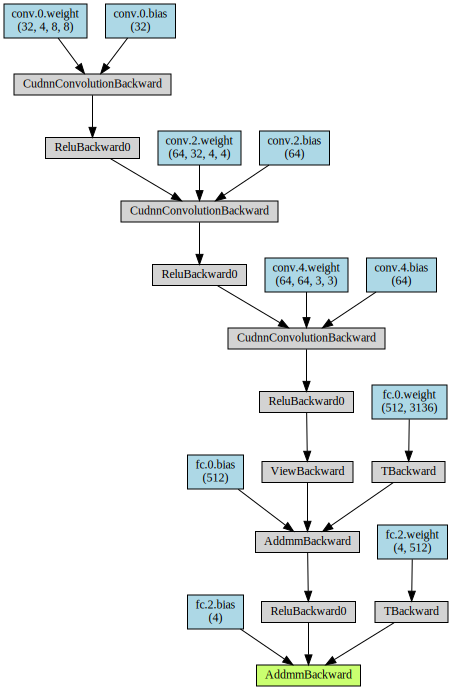

In [15]:
print("ReplayMemory will require {}gb of GPU RAM".format(round(REPLAY_SIZE * 32 * 84 * 84 / 1e+9, 2)))
class ColabArgParse():
    def __init__(self, cuda, env, reward, model):
        self.cuda = cuda
        self.env = env
        self.reward = reward
        self.model = model

args = ColabArgParse(device, ENV_NAME, MEAN_REWARD_BOUND, MODEL)

env = make_env(args.env, frame_skip = FRAME_SKIPPING)
net = DQN(env.observation_space.shape, env.action_space.n).to(device)
target_net = DQN(env.observation_space.shape, env.action_space.n).to(device)

replay_memory = ExperienceReplay(REPLAY_SIZE)
agent = Agent(env, replay_memory)
epsilon = EPSILON_START

summary(net, env.observation_space.shape)
print(net)
make_dot(net(torch.zeros([1,*env.observation_space.shape]).to(device)), params=dict(net.named_parameters()))


In [0]:
def create_animation(net, args, epsilon = 0.05, device = 'cuda', try_num = 10):

    def display_frames_as_gif(frames):
        """
        Displays a list of frames as a gif, with controls
        """
        #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
        patch = plt.imshow(frames[0])
        plt.axis('off')

        def animate(i):
            patch.set_data(frames[i])

        anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=100)
        rc('animation', html='jshtml')
        return anim

    best_reward, best_frames = -100, None
    for i in range(try_num): # try several times and return the best-scored epsisode
        agent._reset()
        frames = []
        for t in range(1000):
            tmp_reward = agent.play_step(net, epsilon = 0.05, device = device)
            frames.append(agent.env.render(mode = 'rgb_array'))
            if tmp_reward is not None:
                break
        print(f'  --Try {i}: t={t}, reward={tmp_reward}', end = '')
        if tmp_reward is not None and tmp_reward>best_reward:
            best_reward = tmp_reward
            best_frames = frames.copy()
            best_t = t
            print(f' Best reward updated')
        else:
            print()

    print('  --Generating animation..')
    anim = display_frames_as_gif(best_frames)
    print(f' --Animationm from {len(best_frames)} frames with reward {best_reward} generated')
    return anim, len(best_frames), best_reward

In [0]:
def save_model_animation(net, args, T):
    torch.save(net.state_dict(), f'{args.env}-{T}.dat')
    torch.save(net.state_dict(), os.path.join(SAVE_FOLDER, f'{args.env}-{T}.dat'))
    pickle.dump(total_rewards,open(os.path.join(SAVE_FOLDER, 'output.pkl'),'wb'))

    anim, t, tot_r = create_animation(net, args, epsilon = 0.05, device = device, try_num=10)

    anim_save_file_name = os.path.join(SAVE_FOLDER, f'{args.env}-{T}-{t}frame_{tot_r}')
    anim.save(f'{anim_save_file_name}.mp4')
    anim.save(f'{anim_save_file_name}.gif', writer='matplotlib.animation.PillowWriter', fps=30)

In [23]:
if LOAD_MODEL_NAME:
    net.load_state_dict(torch.load(os.path.join(SAVE_FOLDER, LOAD_MODEL_NAME)))
    target_net.load_state_dict(net.state_dict())
    total_rewards = pickle.load(open(os.path.join(SAVE_FOLDER, 'output.pkl'), 'rb'))
    print("Models loaded from Google Drive!")
    # Lower exploration rate IMPORTANT
    EPSILON_START = EPSILON_FINAL
    print(f'Set epsilon start as {EPSILON_START}')


Models loaded from Google Drive!
Set epsilon start as 0.1


In [0]:
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay = 1e-5)

In [0]:
total_rewards = []
best_mean_reward = None
frame_idx = 0
timestep_frame = 0
timestep = time.time()

944 frames: done 3 games, mean reward 39.667,  316 frame/episode, eps 0.1, speed 312.54 f/s
1708 frames: done 6 games, mean reward 35.833,  188 frame/episode, eps 0.1, speed 316.58 f/s
2577 frames: done 9 games, mean reward 35.556,  315 frame/episode, eps 0.1, speed 310.6 f/s
3513 frames: done 12 games, mean reward 36.167,  362 frame/episode, eps 0.1, speed 320.78 f/s
4370 frames: done 15 games, mean reward 39.267,  268 frame/episode, eps 0.1, speed 336.39 f/s
5433 frames: done 18 games, mean reward 49.167,  386 frame/episode, eps 0.1, speed 332.69 f/s
6190 frames: done 21 games, mean reward 47.524,  223 frame/episode, eps 0.1, speed 331.55 f/s
7204 frames: done 24 games, mean reward 48.375,  286 frame/episode, eps 0.1, speed 334.71 f/s
7972 frames: done 27 games, mean reward 46.926,  232 frame/episode, eps 0.1, speed 327.87 f/s
8813 frames: done 30 games, mean reward 44.6,  336 frame/episode, eps 0.1, speed 329.46 f/s
9672 frames: done 33 games, mean reward 44.121,  249 frame/episode,

MovieWriter matplotlib.animation.PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


57781 frames: done 201 games, mean reward 34.77,  289 frame/episode, eps 0.1, speed 13.24 f/s
58421 frames: done 204 games, mean reward 34.27,  226 frame/episode, eps 0.1, speed 79.22 f/s
59341 frames: done 207 games, mean reward 33.93,  304 frame/episode, eps 0.1, speed 81.0 f/s
60101 frames: done 210 games, mean reward 34.02,  202 frame/episode, eps 0.1, speed 81.02 f/s
60942 frames: done 213 games, mean reward 34.24,  343 frame/episode, eps 0.1, speed 82.46 f/s
61744 frames: done 216 games, mean reward 33.62,  282 frame/episode, eps 0.1, speed 81.18 f/s
62665 frames: done 219 games, mean reward 34.28,  259 frame/episode, eps 0.1, speed 80.83 f/s
63437 frames: done 222 games, mean reward 34.26,  254 frame/episode, eps 0.1, speed 78.67 f/s
64441 frames: done 225 games, mean reward 34.42,  305 frame/episode, eps 0.1, speed 80.67 f/s
65116 frames: done 228 games, mean reward 34.41,  141 frame/episode, eps 0.1, speed 81.32 f/s
66021 frames: done 231 games, mean reward 33.62,  285 frame/e

MovieWriter matplotlib.animation.PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


New best mean reward 34.81 -> 33.49, model saved
113177 frames: done 402 games, mean reward 34.15,  314 frame/episode, eps 0.1, speed 74.67 f/s
114055 frames: done 405 games, mean reward 34.49,  270 frame/episode, eps 0.1, speed 75.7 f/s
114827 frames: done 408 games, mean reward 33.94,  197 frame/episode, eps 0.1, speed 76.58 f/s
115717 frames: done 411 games, mean reward 34.39,  299 frame/episode, eps 0.1, speed 75.99 f/s
116412 frames: done 414 games, mean reward 34.73,  235 frame/episode, eps 0.1, speed 76.02 f/s
117342 frames: done 417 games, mean reward 34.38,  306 frame/episode, eps 0.1, speed 75.02 f/s
118029 frames: done 420 games, mean reward 34.27,  249 frame/episode, eps 0.1, speed 75.53 f/s
118767 frames: done 423 games, mean reward 34.43,  267 frame/episode, eps 0.1, speed 75.91 f/s
119621 frames: done 426 games, mean reward 34.15,  300 frame/episode, eps 0.1, speed 75.87 f/s
120353 frames: done 429 games, mean reward 34.04,  250 frame/episode, eps 0.1, speed 75.38 f/s
12

MovieWriter matplotlib.animation.PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


New best mean reward 33.49 -> 33.19, model saved
168207 frames: done 603 games, mean reward 33.39,  230 frame/episode, eps 0.1, speed 67.31 f/s
169322 frames: done 606 games, mean reward 33.69,  383 frame/episode, eps 0.1, speed 66.15 f/s
170190 frames: done 609 games, mean reward 33.78,  285 frame/episode, eps 0.1, speed 67.28 f/s
170931 frames: done 612 games, mean reward 33.56,  264 frame/episode, eps 0.1, speed 67.85 f/s
171711 frames: done 615 games, mean reward 33.29,  375 frame/episode, eps 0.1, speed 67.04 f/s
172443 frames: done 618 games, mean reward 33.25,  204 frame/episode, eps 0.1, speed 65.62 f/s
173239 frames: done 621 games, mean reward 33.04,  251 frame/episode, eps 0.1, speed 67.42 f/s
173996 frames: done 624 games, mean reward 32.88,  189 frame/episode, eps 0.1, speed 66.62 f/s
174675 frames: done 627 games, mean reward 32.27,  217 frame/episode, eps 0.1, speed 66.84 f/s
175477 frames: done 630 games, mean reward 31.96,  190 frame/episode, eps 0.1, speed 66.46 f/s
1

MovieWriter matplotlib.animation.PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


New best mean reward 33.19 -> 35.51, model saved
224603 frames: done 801 games, mean reward 35.59,  346 frame/episode, eps 0.1, speed 8.48 f/s
225447 frames: done 804 games, mean reward 35.53,  189 frame/episode, eps 0.1, speed 62.8 f/s
226320 frames: done 807 games, mean reward 35.11,  301 frame/episode, eps 0.1, speed 63.51 f/s
227038 frames: done 810 games, mean reward 34.89,  317 frame/episode, eps 0.1, speed 64.02 f/s
228042 frames: done 813 games, mean reward 35.35,  401 frame/episode, eps 0.1, speed 63.59 f/s
228865 frames: done 816 games, mean reward 34.55,  316 frame/episode, eps 0.1, speed 64.17 f/s
229962 frames: done 819 games, mean reward 34.45,  326 frame/episode, eps 0.1, speed 64.82 f/s
230914 frames: done 822 games, mean reward 34.5,  325 frame/episode, eps 0.1, speed 64.09 f/s
231844 frames: done 825 games, mean reward 35.26,  313 frame/episode, eps 0.1, speed 64.73 f/s
232558 frames: done 828 games, mean reward 34.66,  216 frame/episode, eps 0.1, speed 64.88 f/s
2333

MovieWriter matplotlib.animation.PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


New best mean reward 35.51 -> 36.26, model saved
283202 frames: done 1002 games, mean reward 36.3,  271 frame/episode, eps 0.1, speed 64.41 f/s
284221 frames: done 1005 games, mean reward 36.16,  408 frame/episode, eps 0.1, speed 63.95 f/s
285018 frames: done 1008 games, mean reward 35.79,  311 frame/episode, eps 0.1, speed 63.98 f/s
285972 frames: done 1011 games, mean reward 35.09,  221 frame/episode, eps 0.1, speed 64.88 f/s
286577 frames: done 1014 games, mean reward 34.56,  163 frame/episode, eps 0.1, speed 66.01 f/s
287388 frames: done 1017 games, mean reward 34.5,  265 frame/episode, eps 0.1, speed 64.85 f/s
288122 frames: done 1020 games, mean reward 34.27,  220 frame/episode, eps 0.1, speed 65.83 f/s
288985 frames: done 1023 games, mean reward 34.25,  249 frame/episode, eps 0.1, speed 64.89 f/s
289850 frames: done 1026 games, mean reward 34.63,  231 frame/episode, eps 0.1, speed 65.35 f/s
290746 frames: done 1029 games, mean reward 34.61,  283 frame/episode, eps 0.1, speed 65.

MovieWriter matplotlib.animation.PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


New best mean reward 36.26 -> 39.76, model saved
342425 frames: done 1203 games, mean reward 39.8,  316 frame/episode, eps 0.1, speed 65.3 f/s
343218 frames: done 1206 games, mean reward 40.09,  305 frame/episode, eps 0.1, speed 66.03 f/s
344202 frames: done 1209 games, mean reward 40.43,  303 frame/episode, eps 0.1, speed 66.25 f/s
344965 frames: done 1212 games, mean reward 40.46,  210 frame/episode, eps 0.1, speed 65.01 f/s
345801 frames: done 1215 games, mean reward 40.17,  308 frame/episode, eps 0.1, speed 66.18 f/s
346472 frames: done 1218 games, mean reward 40.3,  189 frame/episode, eps 0.1, speed 66.45 f/s
347471 frames: done 1221 games, mean reward 40.1,  217 frame/episode, eps 0.1, speed 66.86 f/s
348186 frames: done 1224 games, mean reward 39.6,  220 frame/episode, eps 0.1, speed 66.85 f/s
348997 frames: done 1227 games, mean reward 39.01,  235 frame/episode, eps 0.1, speed 66.31 f/s
349703 frames: done 1230 games, mean reward 38.45,  317 frame/episode, eps 0.1, speed 67.15 

MovieWriter matplotlib.animation.PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


New best mean reward 39.76 -> 35.72, model saved
397420 frames: done 1401 games, mean reward 35.68,  293 frame/episode, eps 0.1, speed 6.96 f/s
398377 frames: done 1404 games, mean reward 36.05,  299 frame/episode, eps 0.1, speed 65.97 f/s
399332 frames: done 1407 games, mean reward 35.12,  402 frame/episode, eps 0.1, speed 67.12 f/s
400207 frames: done 1410 games, mean reward 35.16,  227 frame/episode, eps 0.1, speed 65.62 f/s
401160 frames: done 1413 games, mean reward 35.85,  325 frame/episode, eps 0.1, speed 66.41 f/s
401952 frames: done 1416 games, mean reward 35.86,  238 frame/episode, eps 0.1, speed 65.59 f/s
402712 frames: done 1419 games, mean reward 35.79,  270 frame/episode, eps 0.1, speed 66.08 f/s
403529 frames: done 1422 games, mean reward 35.8,  240 frame/episode, eps 0.1, speed 66.28 f/s
404540 frames: done 1425 games, mean reward 35.96,  303 frame/episode, eps 0.1, speed 65.33 f/s
405395 frames: done 1428 games, mean reward 35.67,  288 frame/episode, eps 0.1, speed 67.

MovieWriter matplotlib.animation.PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


New best mean reward 35.72 -> 36.89, model saved
454627 frames: done 1602 games, mean reward 37.51,  261 frame/episode, eps 0.1, speed 67.18 f/s
455567 frames: done 1605 games, mean reward 37.97,  286 frame/episode, eps 0.1, speed 67.38 f/s
456490 frames: done 1608 games, mean reward 37.89,  299 frame/episode, eps 0.1, speed 67.66 f/s
457282 frames: done 1611 games, mean reward 37.91,  310 frame/episode, eps 0.1, speed 65.34 f/s
458124 frames: done 1614 games, mean reward 37.36,  228 frame/episode, eps 0.1, speed 67.18 f/s
459050 frames: done 1617 games, mean reward 37.53,  336 frame/episode, eps 0.1, speed 67.39 f/s
459905 frames: done 1620 games, mean reward 37.39,  283 frame/episode, eps 0.1, speed 66.09 f/s
460667 frames: done 1623 games, mean reward 37.12,  253 frame/episode, eps 0.1, speed 65.96 f/s
461804 frames: done 1626 games, mean reward 37.48,  627 frame/episode, eps 0.1, speed 66.95 f/s
462833 frames: done 1629 games, mean reward 37.93,  453 frame/episode, eps 0.1, speed 6

MovieWriter matplotlib.animation.PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


New best mean reward 36.89 -> 31.1, model saved
509636 frames: done 1803 games, mean reward 30.73,  202 frame/episode, eps 0.1, speed 66.97 f/s
510346 frames: done 1806 games, mean reward 30.7,  247 frame/episode, eps 0.1, speed 67.48 f/s
511094 frames: done 1809 games, mean reward 30.03,  257 frame/episode, eps 0.1, speed 66.21 f/s
512034 frames: done 1812 games, mean reward 32.46,  389 frame/episode, eps 0.1, speed 67.93 f/s
512760 frames: done 1815 games, mean reward 32.68,  220 frame/episode, eps 0.1, speed 67.23 f/s
513594 frames: done 1818 games, mean reward 33.12,  252 frame/episode, eps 0.1, speed 65.87 f/s
514288 frames: done 1821 games, mean reward 33.47,  171 frame/episode, eps 0.1, speed 65.82 f/s
515177 frames: done 1824 games, mean reward 33.95,  299 frame/episode, eps 0.1, speed 66.93 f/s
515970 frames: done 1827 games, mean reward 33.78,  263 frame/episode, eps 0.1, speed 66.95 f/s
516897 frames: done 1830 games, mean reward 33.71,  324 frame/episode, eps 0.1, speed 67.

MovieWriter matplotlib.animation.PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


New best mean reward 31.1 -> 35.4, model saved
563591 frames: done 2001 games, mean reward 35.84,  354 frame/episode, eps 0.1, speed 7.45 f/s
564495 frames: done 2004 games, mean reward 36.15,  354 frame/episode, eps 0.1, speed 61.59 f/s
565255 frames: done 2007 games, mean reward 36.17,  280 frame/episode, eps 0.1, speed 61.33 f/s
566124 frames: done 2010 games, mean reward 35.58,  271 frame/episode, eps 0.1, speed 66.88 f/s
566872 frames: done 2013 games, mean reward 35.59,  271 frame/episode, eps 0.1, speed 66.8 f/s
567731 frames: done 2016 games, mean reward 35.95,  276 frame/episode, eps 0.1, speed 65.95 f/s
568604 frames: done 2019 games, mean reward 36.16,  246 frame/episode, eps 0.1, speed 65.53 f/s
569399 frames: done 2022 games, mean reward 36.4,  319 frame/episode, eps 0.1, speed 65.36 f/s
570213 frames: done 2025 games, mean reward 36.29,  317 frame/episode, eps 0.1, speed 66.7 f/s
571127 frames: done 2028 games, mean reward 36.34,  283 frame/episode, eps 0.1, speed 66.29 f

MovieWriter matplotlib.animation.PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


New best mean reward 35.4 -> 37.18, model saved
621324 frames: done 2202 games, mean reward 37.14,  116 frame/episode, eps 0.1, speed 65.94 f/s
622164 frames: done 2205 games, mean reward 36.34,  272 frame/episode, eps 0.1, speed 66.21 f/s
623069 frames: done 2208 games, mean reward 36.72,  353 frame/episode, eps 0.1, speed 67.07 f/s
623981 frames: done 2211 games, mean reward 36.3,  413 frame/episode, eps 0.1, speed 67.18 f/s
624781 frames: done 2214 games, mean reward 36.0,  209 frame/episode, eps 0.1, speed 67.6 f/s
625800 frames: done 2217 games, mean reward 36.15,  287 frame/episode, eps 0.1, speed 65.94 f/s
626619 frames: done 2220 games, mean reward 35.63,  315 frame/episode, eps 0.1, speed 66.82 f/s
627380 frames: done 2223 games, mean reward 35.8,  277 frame/episode, eps 0.1, speed 63.75 f/s
628298 frames: done 2226 games, mean reward 36.26,  318 frame/episode, eps 0.1, speed 66.82 f/s
629061 frames: done 2229 games, mean reward 35.64,  223 frame/episode, eps 0.1, speed 66.32 

MovieWriter matplotlib.animation.PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


New best mean reward 37.18 -> 37.03, model saved
676933 frames: done 2403 games, mean reward 36.89,  287 frame/episode, eps 0.1, speed 66.33 f/s
677739 frames: done 2406 games, mean reward 37.32,  267 frame/episode, eps 0.1, speed 66.52 f/s
678724 frames: done 2409 games, mean reward 37.97,  310 frame/episode, eps 0.1, speed 66.71 f/s
679556 frames: done 2412 games, mean reward 38.42,  277 frame/episode, eps 0.1, speed 66.73 f/s
680386 frames: done 2415 games, mean reward 38.28,  257 frame/episode, eps 0.1, speed 66.6 f/s
681161 frames: done 2418 games, mean reward 38.09,  303 frame/episode, eps 0.1, speed 65.35 f/s
681964 frames: done 2421 games, mean reward 37.89,  301 frame/episode, eps 0.1, speed 66.67 f/s
682691 frames: done 2424 games, mean reward 36.23,  210 frame/episode, eps 0.1, speed 66.91 f/s
683611 frames: done 2427 games, mean reward 36.33,  279 frame/episode, eps 0.1, speed 66.49 f/s
684341 frames: done 2430 games, mean reward 36.28,  182 frame/episode, eps 0.1, speed 66

MovieWriter matplotlib.animation.PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


New best mean reward 37.03 -> 35.71, model saved
733084 frames: done 2601 games, mean reward 35.64,  398 frame/episode, eps 0.1, speed 5.94 f/s
733859 frames: done 2604 games, mean reward 34.9,  271 frame/episode, eps 0.1, speed 66.62 f/s
734666 frames: done 2607 games, mean reward 35.09,  229 frame/episode, eps 0.1, speed 66.8 f/s
735445 frames: done 2610 games, mean reward 35.39,  255 frame/episode, eps 0.1, speed 65.86 f/s
736310 frames: done 2613 games, mean reward 35.39,  207 frame/episode, eps 0.1, speed 66.73 f/s
737053 frames: done 2616 games, mean reward 35.09,  347 frame/episode, eps 0.1, speed 66.75 f/s
737895 frames: done 2619 games, mean reward 35.31,  287 frame/episode, eps 0.1, speed 66.73 f/s
738634 frames: done 2622 games, mean reward 35.27,  256 frame/episode, eps 0.1, speed 67.6 f/s
739565 frames: done 2625 games, mean reward 35.62,  296 frame/episode, eps 0.1, speed 67.22 f/s
740394 frames: done 2628 games, mean reward 34.98,  244 frame/episode, eps 0.1, speed 66.9 

MovieWriter matplotlib.animation.PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


New best mean reward 35.71 -> 34.93, model saved
788957 frames: done 2802 games, mean reward 35.37,  314 frame/episode, eps 0.1, speed 62.33 f/s
789681 frames: done 2805 games, mean reward 35.03,  257 frame/episode, eps 0.1, speed 63.54 f/s
790412 frames: done 2808 games, mean reward 34.74,  155 frame/episode, eps 0.1, speed 63.41 f/s
791221 frames: done 2811 games, mean reward 35.35,  298 frame/episode, eps 0.1, speed 63.64 f/s
792171 frames: done 2814 games, mean reward 35.93,  320 frame/episode, eps 0.1, speed 62.3 f/s
793033 frames: done 2817 games, mean reward 36.22,  226 frame/episode, eps 0.1, speed 61.27 f/s
793712 frames: done 2820 games, mean reward 35.74,  255 frame/episode, eps 0.1, speed 59.84 f/s
794845 frames: done 2823 games, mean reward 37.69,  386 frame/episode, eps 0.1, speed 63.82 f/s
795832 frames: done 2826 games, mean reward 39.63,  374 frame/episode, eps 0.1, speed 62.9 f/s
796558 frames: done 2829 games, mean reward 39.71,  254 frame/episode, eps 0.1, speed 62.

MovieWriter matplotlib.animation.PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


New best mean reward 34.93 -> 36.84, model saved
844707 frames: done 3003 games, mean reward 37.01,  300 frame/episode, eps 0.1, speed 66.08 f/s
845520 frames: done 3006 games, mean reward 36.59,  291 frame/episode, eps 0.1, speed 64.94 f/s
846376 frames: done 3009 games, mean reward 37.77,  372 frame/episode, eps 0.1, speed 64.5 f/s
847191 frames: done 3012 games, mean reward 37.49,  198 frame/episode, eps 0.1, speed 64.54 f/s
847950 frames: done 3015 games, mean reward 36.94,  281 frame/episode, eps 0.1, speed 65.48 f/s
848591 frames: done 3018 games, mean reward 34.4,  230 frame/episode, eps 0.1, speed 64.91 f/s
849381 frames: done 3021 games, mean reward 33.93,  222 frame/episode, eps 0.1, speed 64.82 f/s
850181 frames: done 3024 games, mean reward 34.32,  261 frame/episode, eps 0.1, speed 64.79 f/s
851153 frames: done 3027 games, mean reward 34.49,  457 frame/episode, eps 0.1, speed 64.96 f/s
851977 frames: done 3030 games, mean reward 34.53,  272 frame/episode, eps 0.1, speed 63.

MovieWriter matplotlib.animation.PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


New best mean reward 36.84 -> 34.7, model saved
899959 frames: done 3201 games, mean reward 34.88,  227 frame/episode, eps 0.1, speed 3.81 f/s
900776 frames: done 3204 games, mean reward 34.33,  284 frame/episode, eps 0.1, speed 67.25 f/s
901653 frames: done 3207 games, mean reward 34.42,  248 frame/episode, eps 0.1, speed 65.92 f/s
902492 frames: done 3210 games, mean reward 34.0,  304 frame/episode, eps 0.1, speed 65.59 f/s
903423 frames: done 3213 games, mean reward 34.34,  278 frame/episode, eps 0.1, speed 66.2 f/s
904240 frames: done 3216 games, mean reward 33.79,  179 frame/episode, eps 0.1, speed 65.83 f/s
905041 frames: done 3219 games, mean reward 35.77,  134 frame/episode, eps 0.1, speed 63.61 f/s
905925 frames: done 3222 games, mean reward 35.47,  304 frame/episode, eps 0.1, speed 65.79 f/s
906738 frames: done 3225 games, mean reward 35.79,  236 frame/episode, eps 0.1, speed 63.61 f/s
907562 frames: done 3228 games, mean reward 35.59,  291 frame/episode, eps 0.1, speed 63.87

MovieWriter matplotlib.animation.PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


New best mean reward 34.7 -> 29.11, model saved
955137 frames: done 3402 games, mean reward 29.08,  217 frame/episode, eps 0.1, speed 64.17 f/s
955956 frames: done 3405 games, mean reward 28.87,  328 frame/episode, eps 0.1, speed 64.95 f/s
956820 frames: done 3408 games, mean reward 28.5,  284 frame/episode, eps 0.1, speed 63.82 f/s
957669 frames: done 3411 games, mean reward 27.98,  223 frame/episode, eps 0.1, speed 64.38 f/s
958366 frames: done 3414 games, mean reward 27.86,  208 frame/episode, eps 0.1, speed 64.02 f/s
959049 frames: done 3417 games, mean reward 27.73,  252 frame/episode, eps 0.1, speed 64.76 f/s
959860 frames: done 3420 games, mean reward 27.87,  223 frame/episode, eps 0.1, speed 64.04 f/s
960744 frames: done 3423 games, mean reward 29.24,  237 frame/episode, eps 0.1, speed 64.39 f/s
961589 frames: done 3426 games, mean reward 29.92,  288 frame/episode, eps 0.1, speed 64.46 f/s
962462 frames: done 3429 games, mean reward 29.68,  361 frame/episode, eps 0.1, speed 65.

MovieWriter matplotlib.animation.PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


New best mean reward 29.11 -> 41.74, model saved
1010878 frames: done 3603 games, mean reward 42.2,  257 frame/episode, eps 0.1, speed 65.04 f/s
1011493 frames: done 3606 games, mean reward 41.82,  138 frame/episode, eps 0.1, speed 65.73 f/s
1012324 frames: done 3609 games, mean reward 41.8,  179 frame/episode, eps 0.1, speed 65.75 f/s
1013105 frames: done 3612 games, mean reward 41.69,  259 frame/episode, eps 0.1, speed 65.26 f/s
1013876 frames: done 3615 games, mean reward 41.68,  279 frame/episode, eps 0.1, speed 65.74 f/s
1014682 frames: done 3618 games, mean reward 41.73,  280 frame/episode, eps 0.1, speed 65.99 f/s
1015411 frames: done 3621 games, mean reward 41.43,  162 frame/episode, eps 0.1, speed 65.69 f/s
1016203 frames: done 3624 games, mean reward 42.04,  266 frame/episode, eps 0.1, speed 66.49 f/s
1016991 frames: done 3627 games, mean reward 41.93,  264 frame/episode, eps 0.1, speed 64.94 f/s
1017751 frames: done 3630 games, mean reward 42.12,  299 frame/episode, eps 0.1,

MovieWriter matplotlib.animation.PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


New best mean reward 41.74 -> 37.86, model saved
1064864 frames: done 3801 games, mean reward 37.82,  234 frame/episode, eps 0.1, speed 2.96 f/s
1065638 frames: done 3804 games, mean reward 37.67,  263 frame/episode, eps 0.1, speed 64.98 f/s
1066457 frames: done 3807 games, mean reward 38.52,  328 frame/episode, eps 0.1, speed 65.45 f/s
1067257 frames: done 3810 games, mean reward 38.77,  280 frame/episode, eps 0.1, speed 65.65 f/s
1068180 frames: done 3813 games, mean reward 39.26,  196 frame/episode, eps 0.1, speed 65.17 f/s
1068870 frames: done 3816 games, mean reward 39.39,  241 frame/episode, eps 0.1, speed 66.12 f/s
1069754 frames: done 3819 games, mean reward 39.75,  327 frame/episode, eps 0.1, speed 65.39 f/s
1070507 frames: done 3822 games, mean reward 39.59,  239 frame/episode, eps 0.1, speed 65.62 f/s
1071172 frames: done 3825 games, mean reward 39.34,  241 frame/episode, eps 0.1, speed 65.24 f/s
1071857 frames: done 3828 games, mean reward 38.96,  207 frame/episode, eps 0.1

MovieWriter matplotlib.animation.PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


New best mean reward 37.86 -> 39.44, model saved
1120043 frames: done 4002 games, mean reward 39.57,  239 frame/episode, eps 0.1, speed 63.9 f/s
1120821 frames: done 4005 games, mean reward 39.43,  276 frame/episode, eps 0.1, speed 63.91 f/s
1121618 frames: done 4008 games, mean reward 39.47,  275 frame/episode, eps 0.1, speed 64.52 f/s
1122564 frames: done 4011 games, mean reward 39.08,  218 frame/episode, eps 0.1, speed 64.46 f/s
1123461 frames: done 4014 games, mean reward 39.42,  385 frame/episode, eps 0.1, speed 63.25 f/s
1124392 frames: done 4017 games, mean reward 37.34,  316 frame/episode, eps 0.1, speed 64.67 f/s
1125106 frames: done 4020 games, mean reward 36.69,  191 frame/episode, eps 0.1, speed 64.05 f/s
1126104 frames: done 4023 games, mean reward 36.7,  370 frame/episode, eps 0.1, speed 64.52 f/s
1126821 frames: done 4026 games, mean reward 36.54,  252 frame/episode, eps 0.1, speed 64.94 f/s
1127880 frames: done 4029 games, mean reward 36.54,  302 frame/episode, eps 0.1,

MovieWriter matplotlib.animation.PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


New best mean reward 39.44 -> 37.1, model saved
1175194 frames: done 4203 games, mean reward 37.14,  234 frame/episode, eps 0.1, speed 63.51 f/s
1176046 frames: done 4206 games, mean reward 37.55,  275 frame/episode, eps 0.1, speed 63.64 f/s
1176906 frames: done 4209 games, mean reward 37.46,  197 frame/episode, eps 0.1, speed 64.07 f/s
1177615 frames: done 4212 games, mean reward 37.35,  273 frame/episode, eps 0.1, speed 64.02 f/s
1178371 frames: done 4215 games, mean reward 36.85,  292 frame/episode, eps 0.1, speed 63.78 f/s
1179392 frames: done 4218 games, mean reward 36.91,  462 frame/episode, eps 0.1, speed 63.9 f/s
1180281 frames: done 4221 games, mean reward 39.26,  427 frame/episode, eps 0.1, speed 64.37 f/s
1180994 frames: done 4224 games, mean reward 39.4,  209 frame/episode, eps 0.1, speed 63.27 f/s
1181806 frames: done 4227 games, mean reward 37.42,  347 frame/episode, eps 0.1, speed 64.36 f/s
1182563 frames: done 4230 games, mean reward 37.91,  265 frame/episode, eps 0.1, 

MovieWriter matplotlib.animation.PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


New best mean reward 37.1 -> 36.19, model saved
1229449 frames: done 4401 games, mean reward 36.41,  304 frame/episode, eps 0.1, speed 2.87 f/s
1230358 frames: done 4404 games, mean reward 36.9,  285 frame/episode, eps 0.1, speed 62.79 f/s
1231105 frames: done 4407 games, mean reward 37.13,  242 frame/episode, eps 0.1, speed 66.06 f/s
1232076 frames: done 4410 games, mean reward 38.44,  247 frame/episode, eps 0.1, speed 65.83 f/s
1232779 frames: done 4413 games, mean reward 38.13,  227 frame/episode, eps 0.1, speed 64.23 f/s
1233771 frames: done 4416 games, mean reward 38.53,  299 frame/episode, eps 0.1, speed 66.54 f/s
1234665 frames: done 4419 games, mean reward 38.35,  348 frame/episode, eps 0.1, speed 63.12 f/s
1235642 frames: done 4422 games, mean reward 40.8,  523 frame/episode, eps 0.1, speed 64.74 f/s
1236644 frames: done 4425 games, mean reward 42.53,  410 frame/episode, eps 0.1, speed 65.02 f/s
1237432 frames: done 4428 games, mean reward 42.11,  257 frame/episode, eps 0.1, s

MovieWriter matplotlib.animation.PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


New best mean reward 36.19 -> 31.38, model saved
1283102 frames: done 4602 games, mean reward 31.33,  268 frame/episode, eps 0.1, speed 65.7 f/s
1283979 frames: done 4605 games, mean reward 31.68,  394 frame/episode, eps 0.1, speed 66.65 f/s
1284751 frames: done 4608 games, mean reward 32.05,  300 frame/episode, eps 0.1, speed 66.0 f/s
1285601 frames: done 4611 games, mean reward 31.98,  337 frame/episode, eps 0.1, speed 65.81 f/s
1286439 frames: done 4614 games, mean reward 31.88,  202 frame/episode, eps 0.1, speed 66.22 f/s
1287431 frames: done 4617 games, mean reward 31.97,  309 frame/episode, eps 0.1, speed 65.92 f/s
1288252 frames: done 4620 games, mean reward 32.67,  273 frame/episode, eps 0.1, speed 66.85 f/s
1288944 frames: done 4623 games, mean reward 32.9,  207 frame/episode, eps 0.1, speed 66.92 f/s
1289735 frames: done 4626 games, mean reward 33.39,  169 frame/episode, eps 0.1, speed 65.83 f/s
1290514 frames: done 4629 games, mean reward 33.76,  235 frame/episode, eps 0.1, 

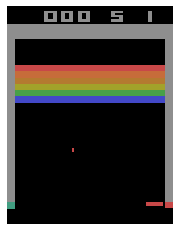

In [36]:
while True:
    frame_idx += 1
    epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY)

    reward = agent.play_step(net, epsilon, device=device)

    if reward is not None: #episode finished
        total_rewards.append(reward)
        delta_frame = frame_idx - timestep_frame
        speed = delta_frame / (time.time() - timestep)
        timestep_frame = frame_idx
        timestep = time.time()
        mean_reward = np.mean(total_rewards[-100:])
        if (len(total_rewards)%3==0):
            print(f"{frame_idx} frames: done {len(total_rewards)} games, mean reward {round(mean_reward,3)}, ",
                    f"{delta_frame:3d} frame/episode, eps {round(epsilon,3)}, speed {round(speed,2)} f/s")

        #if (best_mean_reward is None or best_mean_reward < mean_reward) and len(total_rewards) % MODEL_SAVE_STEP == 0:
        if len(total_rewards) % MODEL_SAVE_STEP == 0:
            save_model_animation(net, args, len(total_rewards))
            if best_mean_reward is not None:
                print("New best mean reward {} -> {}, model saved".format(round(best_mean_reward, 3), round(mean_reward, 3)))
            best_mean_reward = mean_reward
        if mean_reward > args.reward and len(total_rewards) > 10:
            print("Game solved in {} frames! Average score of {}".format(frame_idx, mean_reward))
            break

    if len(replay_memory) < LEARNING_STARTS:
        continue

    if frame_idx % TARGET_UPDATE_FREQ == 0:
        target_net.load_state_dict(net.state_dict())

    optimizer.zero_grad()
    batch = replay_memory.sample(BATCH_SIZE)
    loss_t = calculate_loss(batch, net, target_net, device=device)
    loss_t.backward()
    optimizer.step()

env.close()


Text(0.5, 1.0, 'Moving average of per episodes reward')

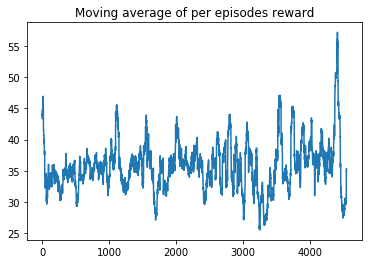

In [25]:
w = 50
plt.plot(np.convolve(np.array(total_rewards), np.ones(w), 'valid') / w)
plt.title('Moving average of per episodes reward')

## Play

In [30]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(600, 400))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1000x800x24', ':1005'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1000x800x24', ':1005'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

  --Try 0: t=287, reward=50.0 Best reward updated
  --Try 1: t=228, reward=27.0
  --Try 2: t=432, reward=219.0 Best reward updated
  --Try 3: t=373, reward=101.0
  --Try 4: t=432, reward=106.0
  --Try 5: t=499, reward=240.0 Best reward updated
  --Try 6: t=236, reward=36.0
  --Try 7: t=278, reward=48.0
  --Try 8: t=381, reward=66.0
  --Try 9: t=262, reward=38.0
  --Generating animation..
 --Animationm from 500 frames with reward 240.0 generated


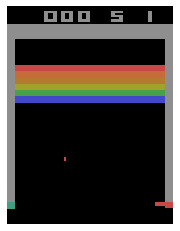

In [29]:
#create animation
anim, t, tot_r = create_animation(net, args, epsilon = 0.05, device = device, try_num=10)
#play mp4
anim

In [0]:
#save to GDrive
T=len(total_rewards)
anim_save_file_name = os.path.join(SAVE_FOLDER, f'{args.env}-{T}-{t}frame_{tot_r}')
anim.save(f'{anim_save_file_name}.mp4')
anim.save(f'{anim_save_file_name}.gif', writer='animation.PillowWriter', fps=30)
